In [6]:
%matplotlib inline

In [7]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from pathlib import Path

In [ ]:
# This notebook creates annual timeseries for CORINE land cover by interpolating data from years 2000, 2006, 2012 and 2018

In [8]:
corine_categories = ['111','112','121','122','123','124','131','132','133','141','142','211','212','213','221','222','223','231','241','242','243','244','311','312','313','321','322','323','324','331','332','333','334','335','411','412','421','422','423','511','512','521','522','523']

In [9]:
def calculate_corine_stats(corine_path, year):
    corine = gpd.read_file(corine_path)
    corine = corine.to_crs(watersheds.crs)  # Ensure both datasets have the same CRS

    corine_stats = []

    column_name = f"CODE_{str(year)[-2:]}"  # Generate the column name dynamically

    for index, watershed in watersheds.iterrows():
        watershed_geom = watershed["geometry"]
        watershed_area = watershed["area"]

        watershed_intersection = gpd.overlay(corine, watersheds.loc[[index]], how="intersection")
        intersection_area = watershed_intersection.geometry.area.sum()

        if intersection_area == 0:
            # No intersection, all fractions are 0
            stats = {
                "Watershed ID": index,  # Replace with actual watershed ID field
                "agr_fra": 0,
                "bare_fra": 0,
                "forest_fra": 0,
                "glac_fra": 0,
                "lake_fra": 0,
                "urban_fra": 0,
                "scrub_fra": 0,
                "wetl_fra": 0
            }
        else:
            # Calculate fractions based on intersection areas
            clc_area = []
            for i in corine_categories:
                clc_area_i = watershed_intersection[watershed_intersection[column_name] == i].geometry.area.sum()
                clc_area.append(clc_area_i)

            ag_code_idx = [corine_categories.index(i) for i in corine_categories if i.startswith('2')]
            agr_fra = sum([clc_area[i] for i in ag_code_idx]) / intersection_area
            bare_fra = sum([clc_area[corine_categories.index(i)] for i in ['332', '333']]) / intersection_area
            forest_fra = sum([clc_area[corine_categories.index(i)] for i in ['311', '312', '313']]) / intersection_area
            scrub_fra = sum([clc_area[corine_categories.index(i)] for i in ['321', '322', '323', '324']]) / intersection_area
            wetlands_fra = sum([clc_area[corine_categories.index(i)] for i in ['411', '412', '421', '422', '423']]) / intersection_area
            glac_fra = clc_area[corine_categories.index('335')] / intersection_area
            lake_fra = clc_area[corine_categories.index('512')] / intersection_area
            urban_fra = sum([clc_area[corine_categories.index(i)] for i in ['111', '112', '121', '122', '123', '124']]) / intersection_area

            stats = {
                "Watershed ID": index, #["ID"],  # Replace with actual watershed ID field
                "agr_fra": agr_fra,
                "bare_fra": bare_fra,
                "forest_fra": forest_fra,
                "glac_fra": glac_fra,
                "lake_fra": lake_fra,
                "urban_fra": urban_fra,
                "scrub_fra": scrub_fra,
                "wetl_fra": wetlands_fra
            }

        corine_stats.append(stats)

    # Create a DataFrame from the list of stats
    corine_stats_df = pd.DataFrame(corine_stats)

    # Add the "Year" column
    corine_stats_df["Year"] = year

    return corine_stats_df

In [10]:
# Read watersheds shapefile
watersheds = gpd.read_file(Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\A_basins_total_upstrm\3_shapefiles\Basins_A.shp"))
watersheds["area"] = watersheds.geometry.area
watersheds = watersheds.set_index('id')

In [11]:
# Define paths to corine shapefiles
corine_2000_path = Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\corine\corine_clc00_is_isn93_lambert_1993_zip\clc00_is.shp")
corine_2006_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\CORINE\CLC06_isn93.shp")
corine_2012_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\CORINE\CLC12_isn93.shp")
corine_2018_path = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\CORINE\CLC18_isn93.shp")

In [12]:
# Calculate corine stats for each year
years = [2000, 2006, 2012, 2018]
corine_paths = [corine_2000_path, corine_2006_path, corine_2012_path, corine_2018_path]
corine_stats = []

# Compute the fractions - This takes a while
for year, corine_path in zip(years, corine_paths):
    print(year)
    stats = calculate_corine_stats(corine_path, year)
    corine_stats.append(stats)

# Save as csv
save_path = Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\corine\corine_watersheds_fractions_python\Basins_A")
for year, dataframe in zip(years,corine_stats):
    dataframe = dataframe.set_index('Watershed ID')
    dataframe.round(3).to_csv(os.path.join(save_path,'corine_%s.csv' % year))

In [56]:
# Interpolate and save a separate file for each stat

def interpolate(results_dataframe):
    df = results_dataframe.copy()
    
    years = list(range(2000, 2019))
    df = df.reindex(index=years)
    df.interpolate(method='linear', inplace=True)
    return(df)

# Create a directory to store the individual catchment CSV files
output_directory = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\2_timeseries\annual\corine")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate through each catchment ID
for catchment_id in corine_stats[0]['Watershed ID']:
    catchment_data_to_be_interpolated = {}

    # Loop through each year's DataFrame and extract data
    for year_df in corine_stats:
        year_df = year_df.set_index('Watershed ID')
        year = year_df["Year"].iloc[0]
        catchment_data = year_df.loc[catchment_id].drop("Year")
        catchment_data_to_be_interpolated[year] = catchment_data

    # Convert the dictionary of interpolated data to a DataFrame
    catchment_data_to_be_interpolated_df = pd.DataFrame(catchment_data_to_be_interpolated).transpose()
    # Interpolate the df
    catchment_interpolated_df = interpolate(catchment_data_to_be_interpolated_df)
    # Save the interpolated data as a CSV file for the catchment
    csv_filename = os.path.join(output_directory, f"ID_{catchment_id}.csv")
    catchment_interpolated_df.round(3).to_csv(csv_filename)

# Check how our calculations compare to previously computed fractions

In [67]:
# Extract our newly computed glacier fractions
glac = corine_stats[3].set_index('Watershed ID')['glac_fra']

# Read glacier fractions based on Hannesdottir et al.
gl_frac_hannesd = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\lamah_ice\A_basins_total_upstrm\2_timeseries\annual\glaciated_area_percentage.csv")
gl_frac_hannesd = pd.read_csv(gl_frac_hannesd)
gl_frac_hannesd = gl_frac_hannesd.set_index('id')

# Read catchment attributes table (our previously computed 2018 corine glac fra from QGIS)
orig_attrs = pd.read_csv(Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\Catchment_attributes.csv"))
orig_attrs = orig_attrs.set_index('id')
orig_corine = orig_attrs[["lc_dom","agr_fra","bare_fra","forest_fra","glac_fra","lake_fra","urban_fra"]]

In [79]:
glac = pd.DataFrame({'newly_computed': glac})  # Replace 'column_name1' with the actual column name
gl_frac_hannesd = pd.DataFrame({'from_hannesd': gl_frac_hannesd['2018']/100})  # Replace 'column_name2' with the actual column name
orig_attrs = pd.DataFrame({'previous_corine': orig_attrs['glac_fra']})  # Replace 'column_name3' with the actual column name

# Concatenate the DataFrames vertically
comb = pd.concat([glac, gl_frac_hannesd, orig_attrs], axis=1)


<Axes: >

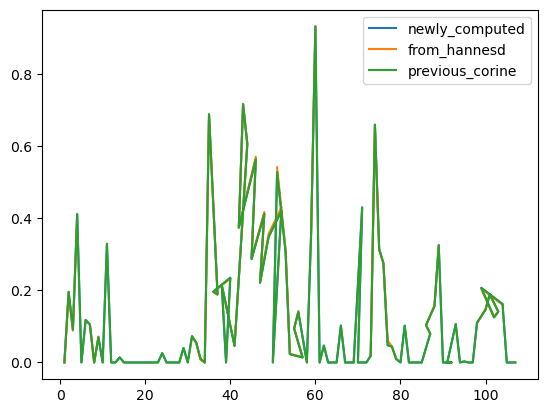

In [82]:
comb.loc[:107].plot()

In [83]:
comb

,newly_computed,from_hannesd,previous_corine
1,0.000000,0.00000,0.000
2,0.195549,0.19048,0.196
3,0.090578,0.08823,0.091
4,0.411176,0.40248,0.411
5,0.000000,NaN,0.000
...,...,...,...
107,0.000000,NaN,0.000
890,0.000000,NaN,0.000
990,0.260757,0.25816,0.261
1010,0.203387,0.20133,0.203


In [ ]:
# Looks good!